In [1]:
import pandas as pd

df = pd.read_csv("aadhaar_demo_monthly_update_superclean.csv")

# Parse date
df["Date"] = pd.to_datetime(df["Date"],errors="coerce",dayfirst=True)

# Basic sanity check
print(df.head())
print(df.info())

   Unnamed: 0       Date             State     District  Pincode  \
0           0 2025-01-03       West Bengal  Murshidabad   742402   
1           1 2025-01-03           Manipur      Thoubal   795101   
2           2 2025-01-03         Rajasthan       Sirohi   307513   
3           3 2025-01-03       West Bengal      Hooghly   712311   
4           4 2025-01-03  Himachal Pradesh          Una   174301   

   Demo_age_5_17  Demo_age_17+    Month  
0           15.0         165.0  2025-03  
1           12.0         114.0  2025-03  
2           18.0         201.0  2025-03  
3           27.0         480.0  2025-03  
4           24.0         243.0  2025-03  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337124 entries, 0 to 2337123
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Unnamed: 0     int64         
 1   Date           datetime64[ns]
 2   State          object        
 3   District       object        
 4   Pincode     

In [4]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce",dayfirst=True)
# Total population proxy
df["Total"] = df["Demo_age_5_17"] + df["Demo_age_17+"]

# Age composition
df["Child_ratio"] = df["Demo_age_5_17"] / df["Total"]
df["Adult_ratio"] = df["Demo_age_17+"] / df["Total"]

# Age balance (easy to explain)
df["Age_balance"] = df["Demo_age_5_17"] - df["Demo_age_17+"]

# Time features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.to_period("M")

print(df.head())

   Unnamed: 0       Date             State     District  Pincode  \
0           0 2025-01-03       West Bengal  Murshidabad   742402   
1           1 2025-01-03           Manipur      Thoubal   795101   
2           2 2025-01-03         Rajasthan       Sirohi   307513   
3           3 2025-01-03       West Bengal      Hooghly   712311   
4           4 2025-01-03  Himachal Pradesh          Una   174301   

   Demo_age_5_17  Demo_age_17+    Month  Total  Child_ratio  Adult_ratio  \
0           15.0         165.0  2025-01  180.0     0.083333     0.916667   
1           12.0         114.0  2025-01  126.0     0.095238     0.904762   
2           18.0         201.0  2025-01  219.0     0.082192     0.917808   
3           27.0         480.0  2025-01  507.0     0.053254     0.946746   
4           24.0         243.0  2025-01  267.0     0.089888     0.910112   

   Age_balance    Year  
0       -150.0  2025.0  
1       -102.0  2025.0  
2       -183.0  2025.0  
3       -453.0  2025.0  
4       -

In [5]:
state_summary = df.groupby("State").agg(
    total_sum=("Total", "sum"),
    active_months=("Month", "nunique"),
    avg_monthly_total=("Total", "mean"),
    avg_child_ratio=("Child_ratio", "mean")
).reset_index()

print(state_summary.sort_values("avg_monthly_total", ascending=False))

                                       State  total_sum  active_months  \
8                                      Delhi  1087267.0             15   
6                               Chhattisgarh  1727433.0             15   
4                                      Bihar  4448992.0             15   
33                             Uttar Pradesh  8488688.0             15   
21                                   Manipur   292544.0             15   
11                                   Haryana  1031164.0             15   
19                            Madhya Pradesh  2541240.0             15   
14                                 Jharkhand  1307680.0             15   
5                                 Chandigarh    57693.0             15   
20                               Maharashtra  4574162.0             15   
28                                 Rajasthan  2538814.0             15   
35                               West Bengal  3749157.0             15   
34                               Uttar

In [6]:
district_summary = df.groupby(["State", "District"]).agg(
    avg_monthly_total=("Total", "mean"),
    avg_child_ratio=("Child_ratio", "mean"),
    active_months=("Month", "nunique")
).reset_index()

In [7]:
from scipy.stats import zscore

state_summary["monthly_total_z"] = zscore(state_summary["avg_monthly_total"])
state_summary["child_ratio_z"] = zscore(state_summary["avg_child_ratio"])

state_summary["Anomaly"] = (
    (state_summary["monthly_total_z"].abs() > 3) |
    (state_summary["child_ratio_z"].abs() > 3)
)

anomalies = state_summary[state_summary["Anomaly"]]
print(anomalies)

   State  total_sum  active_months  avg_monthly_total  avg_child_ratio  \
8  Delhi  1087267.0             15          97.146801         0.091808   

   monthly_total_z  child_ratio_z  Anomaly  
8         4.405863      -0.362024     True  


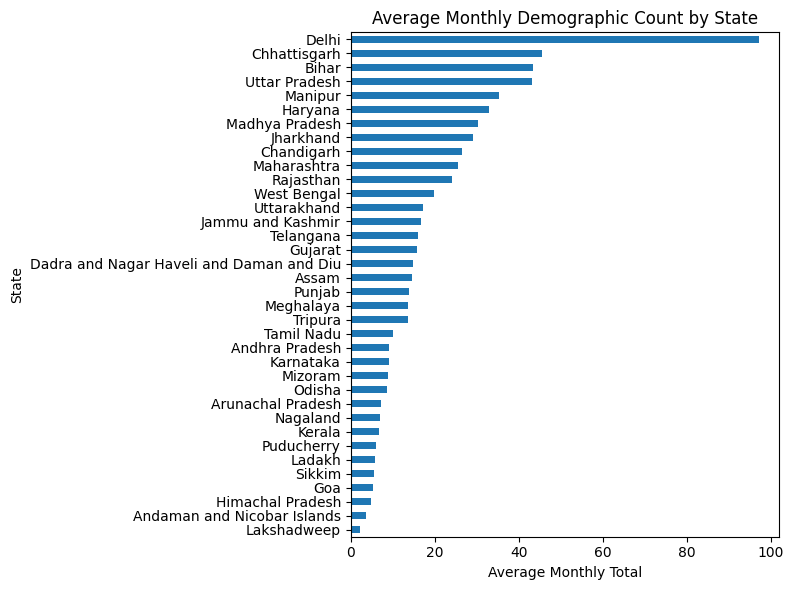

In [8]:
import matplotlib.pyplot as plt

state_summary.sort_values("avg_monthly_total").plot(
    x="State",
    y="avg_monthly_total",
    kind="barh",
    legend=False,
    figsize=(8, 6)
)

plt.title("Average Monthly Demographic Count by State")
plt.xlabel("Average Monthly Total")
plt.tight_layout()
plt.show()

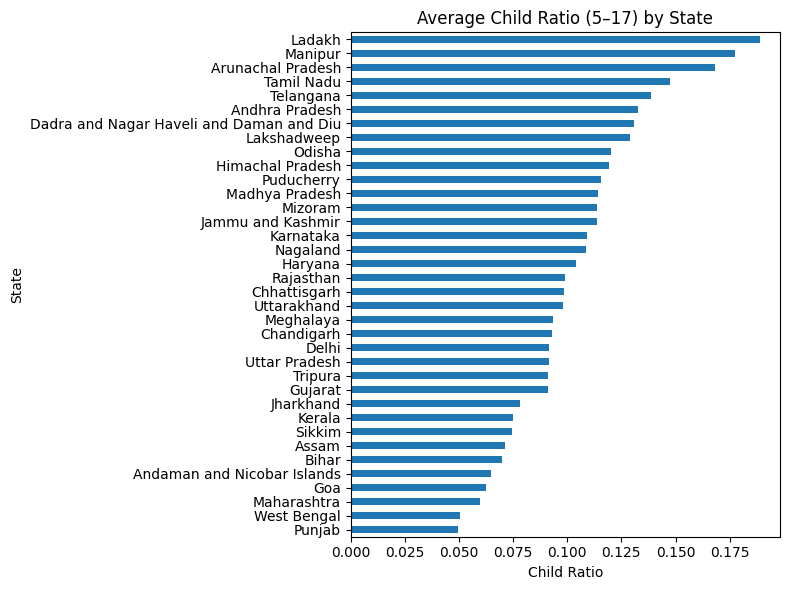

In [9]:
state_summary.sort_values("avg_child_ratio").plot(
    x="State",
    y="avg_child_ratio",
    kind="barh",
    legend=False,
    figsize=(8, 6)
)

plt.title("Average Child Ratio (5–17) by State")
plt.xlabel("Child Ratio")
plt.tight_layout()
plt.show()

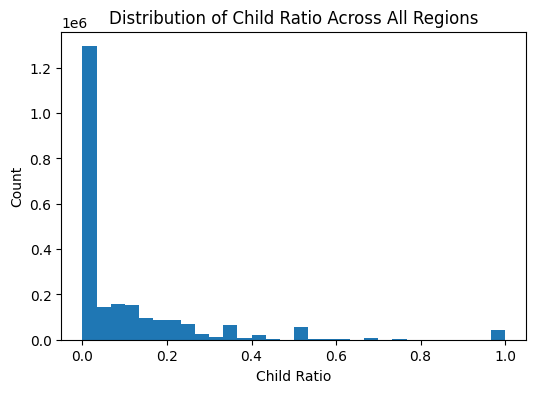

In [10]:
plt.figure(figsize=(6, 4))
plt.hist(df["Child_ratio"], bins=30)
plt.title("Distribution of Child Ratio Across All Regions")
plt.xlabel("Child Ratio")
plt.ylabel("Count")
plt.show()

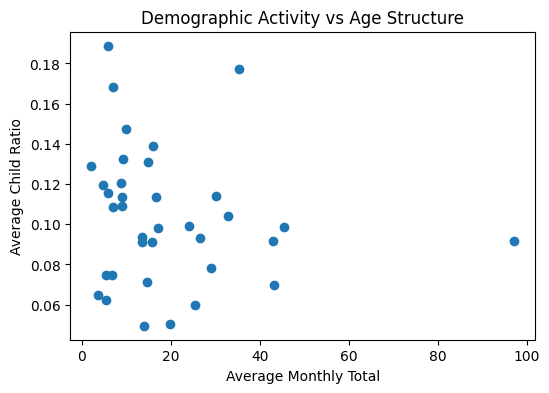

In [11]:
plt.figure(figsize=(6, 4))
plt.scatter(
    state_summary["avg_monthly_total"],
    state_summary["avg_child_ratio"]
)
plt.xlabel("Average Monthly Total")
plt.ylabel("Average Child Ratio")
plt.title("Demographic Activity vs Age Structure")
plt.show()

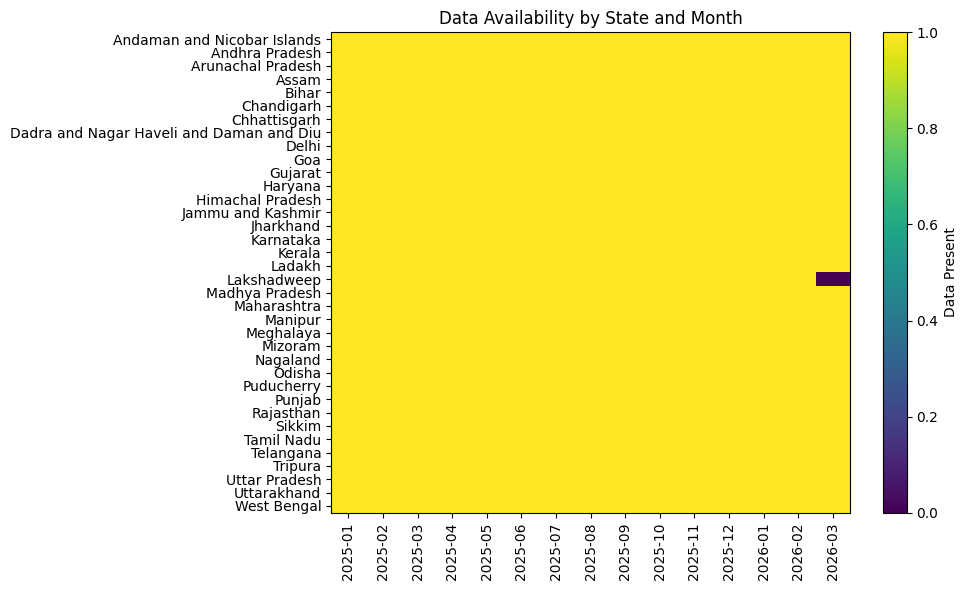

In [12]:
availability = (
    df.groupby(["State", "Month"])
      .size()
      .unstack(fill_value=0)
)

plt.figure(figsize=(10, 6))
plt.imshow(availability > 0, aspect="auto")
plt.yticks(range(len(availability.index)), availability.index)
plt.xticks(range(len(availability.columns)), availability.columns.astype(str), rotation=90)
plt.title("Data Availability by State and Month")
plt.colorbar(label="Data Present")
plt.tight_layout()
plt.show()


In [13]:
from scipy.stats import f_oneway

groups = [
    group["Total"].values
    for _, group in df.groupby("Month")
]

f_stat, p_value = f_oneway(*groups)
print("ANOVA p-value:", p_value)

ANOVA p-value: 0.0


0.0 - Variance LOL. Bakvaas dataset